In [55]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [56]:
f = open("omp_res_slurm.json")
omp = json.load(f)
f.close()

In [57]:
def speedup(serial_time, parallel_time):
    return serial_time / parallel_time
def strong_efficency(serial_time, parallel_time, cores):
    return (serial_time) / (parallel_time * cores)

In [58]:
time_types = ["inf_time", "init_time", "relaxation_time", "negative_cycles_time"]

In [59]:
def key_make(file):
    file = file.replace("graphs/graph_", "graph-").replace(".txt", "").replace("20", "17")
    return f"{file}"

In [60]:
omp_refactored = {}
for i in range(10):
    key = str(i)
    run = omp[key]
    for execution in run:
        if not key_make(execution["input_file"]) in omp_refactored:
            omp_refactored[key_make(execution["input_file"]) ] = {
                "edges": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}, 
                "nodes": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}
            }
        for time_type in time_types:
            omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])][time_type].append(execution["edges"][time_type])
            omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])][time_type].append(execution["nodes"][time_type])
        omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])]["total"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])]["total"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
for key in omp_refactored:
    for cores in range(1, 5):
        omp_refactored[key]["nodes"][cores] = {time_type: np.mean(omp_refactored[key]["nodes"][cores][time_type]) for time_type in time_types + ["total"]}
        omp_refactored[key]["edges"][cores] = {time_type: np.mean(omp_refactored[key]["edges"][cores][time_type]) for time_type in time_types + ["total"]}
    

In [61]:
for graph in omp_refactored.keys():
    for cores in range(1, 5):
        for time_type in time_types + ["total"]:
            omp_refactored[graph]["nodes"][cores][f"{time_type}-speedup"] = speedup(omp_refactored[graph]["nodes"][1][time_type], 
                                                                                        omp_refactored[graph]["nodes"][cores][time_type])
            omp_refactored[graph]["nodes"][cores][f"{time_type}-strong"] = strong_efficency(omp_refactored[graph]["nodes"][1][time_type], 
                                                                                            omp_refactored[graph]["nodes"][cores][time_type], cores)
            omp_refactored[graph]["edges"][cores][f"{time_type}-speedup"] = speedup(omp_refactored[graph]["edges"][1][time_type], 
                                                                                        omp_refactored[graph]["edges"][cores][time_type])
            omp_refactored[graph]["edges"][cores][f"{time_type}-strong"] = strong_efficency(omp_refactored[graph]["edges"][1][time_type], 
                                                                                            omp_refactored[graph]["edges"][cores][time_type], cores)

/tmp/ipykernel_1394/1602110439.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return serial_time / parallel_time
/tmp/ipykernel_1394/1602110439.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return (serial_time) / (parallel_time * cores)


In [62]:
new_omp_nodes = {}
new_omp_edges = {}
for key in omp_refactored:
    new_omp_nodes[key] = {}
    new_omp_edges[key] = {}
    new_omp_nodes[key] = {time_type: np.mean([omp_refactored[key]["nodes"][cores][time_type] for cores in range (1, 5)]) for time_type in time_types}
    new_omp_edges[key] = {time_type: np.mean([omp_refactored[key]["edges"][cores][time_type] for cores in range (1, 5)]) for time_type in time_types}
new_omp_edges = {k:v for k, v in sorted(new_omp_edges.items(), key= lambda x: int(x[0].split("-")[1]))}
new_omp_nodes = {k:v for k, v in sorted(new_omp_nodes.items(), key= lambda x: int(x[0].split("-")[1]))}
new_omp_edges_1 = {k:v for k, v in new_omp_edges.items() if int(k.split("-")[1]) < 10}
new_omp_edges_2 = {k:v for k, v in new_omp_edges.items() if int(k.split("-")[1]) >= 10}
new_omp_nodes_1 = {k:v for k, v in new_omp_nodes.items() if int(k.split("-")[1]) < 10}
new_omp_nodes_2 = {k:v for k, v in new_omp_nodes.items() if int(k.split("-")[1]) >= 10}

In [147]:
a = []
f = open("graphs/graph_weak2.txt")
lines = f.read().splitlines()[1:]
f.close()
for line in lines:
    a.append([int(b) for b in line.split(",")])
np.array(a).shape

(755, 755)

In [230]:
def plot_cumullative_time(data, name):
    outer_keys = list(data.keys())
    inner_keys = list(next(iter(data.values())).keys())
    values = [list(inner_dict.values()) for inner_dict in data.values()]

    # Transpose values for stacking
    transposed_values = list(map(list, zip(*values)))

    # Initialize the bottom values to zeros
    bottom = np.zeros(len(outer_keys))

    # Plotting
    fig, ax = plt.subplots()

    # Bar width
    bar_width = 0.4

    # Positions of the bars on the x-axis
    x = range(len(outer_keys))

    # Plotting each stack
    for i, inner_key in enumerate(inner_keys):
        ax.bar(x, transposed_values[i], bar_width, label=inner_key, bottom=bottom)
        # Update bottom values for the next stack
        bottom = [sum(x) for x in zip(bottom, transposed_values[i])]

    # Adding labels and title
    ax.set_xticks(x)
    ax.set_ylabel("time")
    ax.set_xticklabels(outer_keys)
    ax.legend()
    plt.xticks(rotation=90)
    # Show the plot
    plt.savefig(name, format="pdf", bbox_inches='tight')
    plt.show()

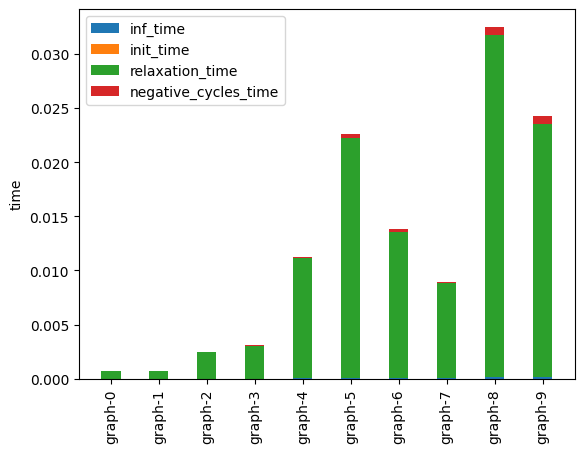

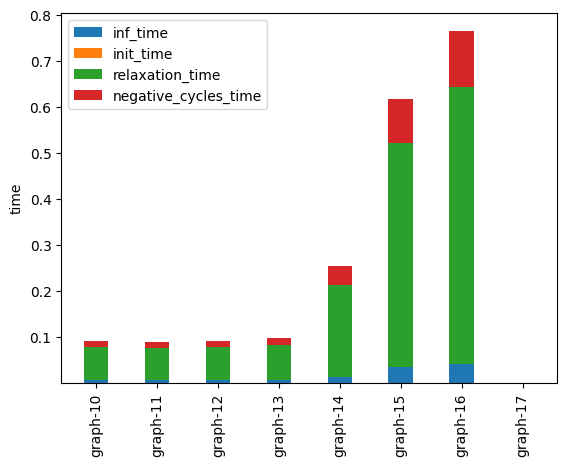

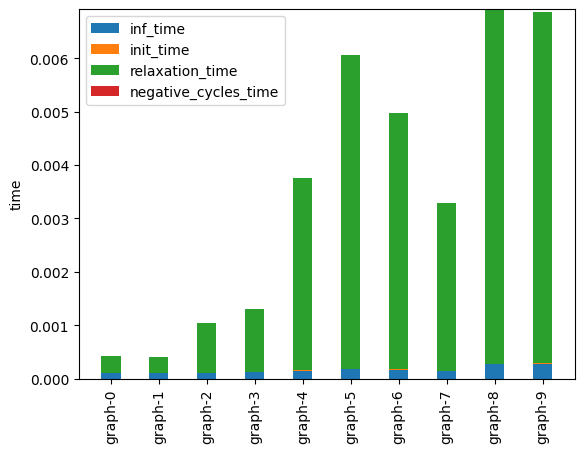

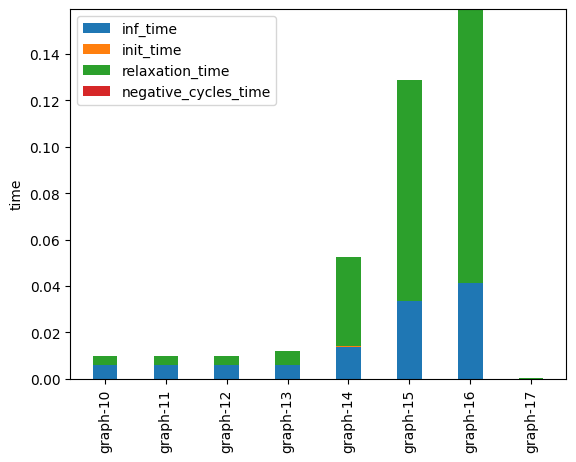

In [231]:
plot_cumullative_time(new_omp_nodes_1, f"imgs/nodes-comp-0-9_omp.pdf")
plot_cumullative_time(new_omp_nodes_2, f"imgs/nodes-comp-10-17_omp.pdf")
plot_cumullative_time(new_omp_edges_1, f"imgs/edges-comp-0-9_omp.pdf")
plot_cumullative_time(new_omp_edges_2, f"imgs/edges-comp-10-17_omp.pdf")

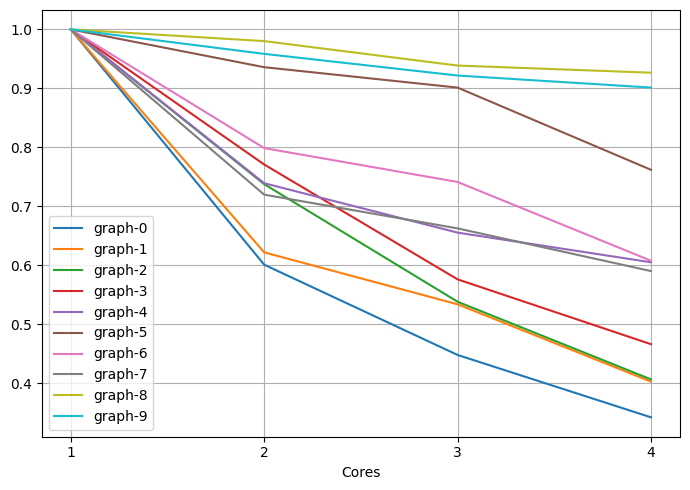

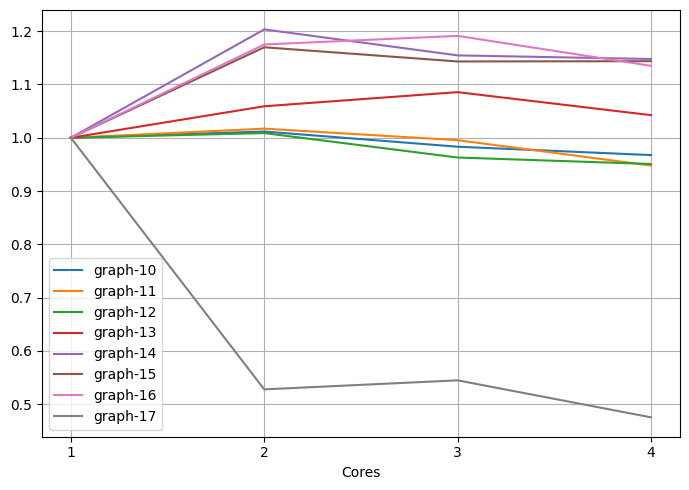

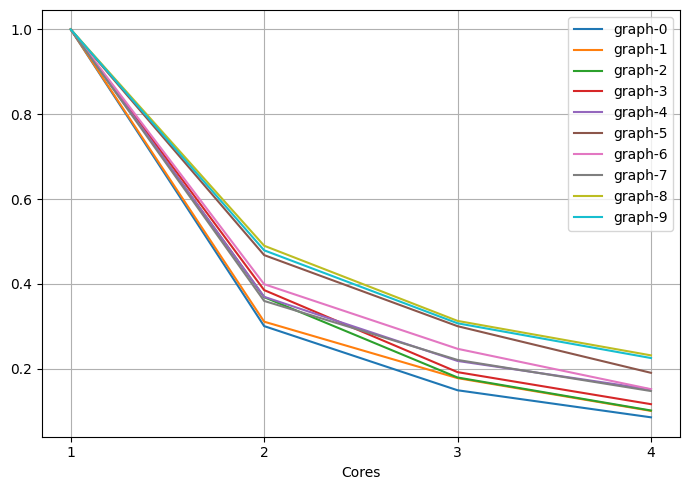

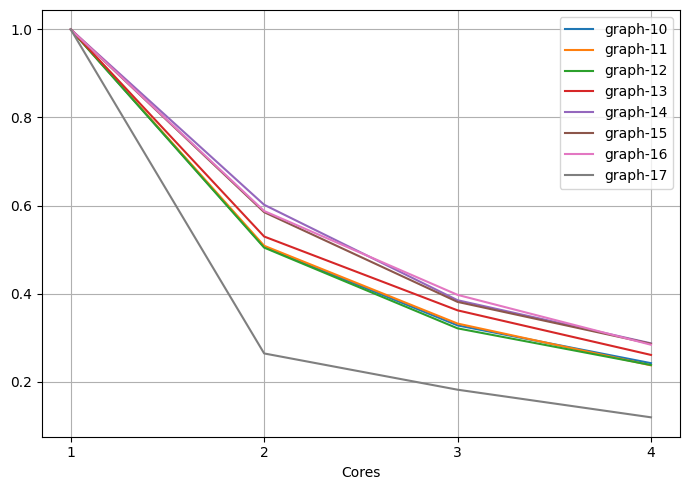

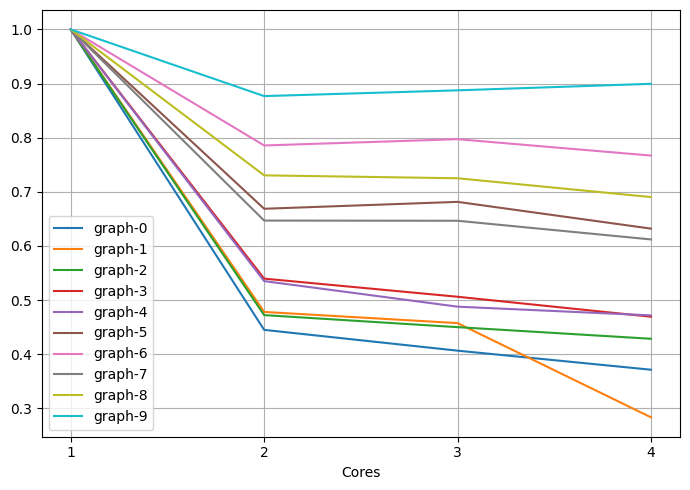

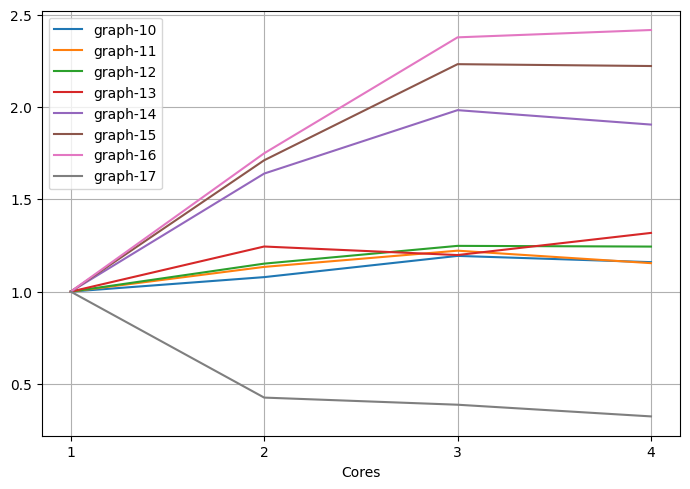

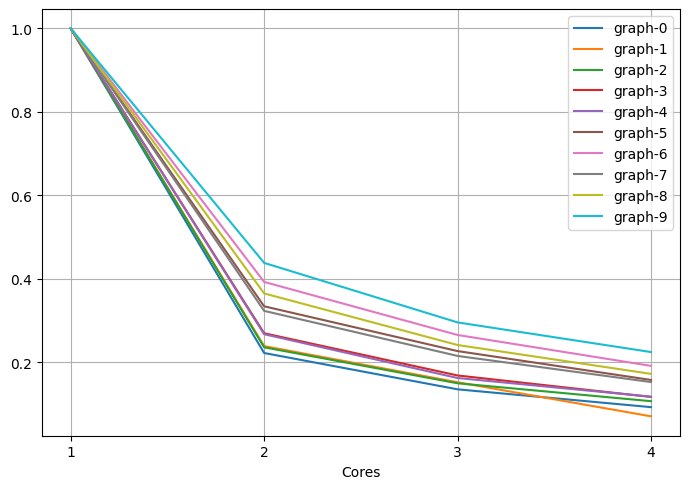

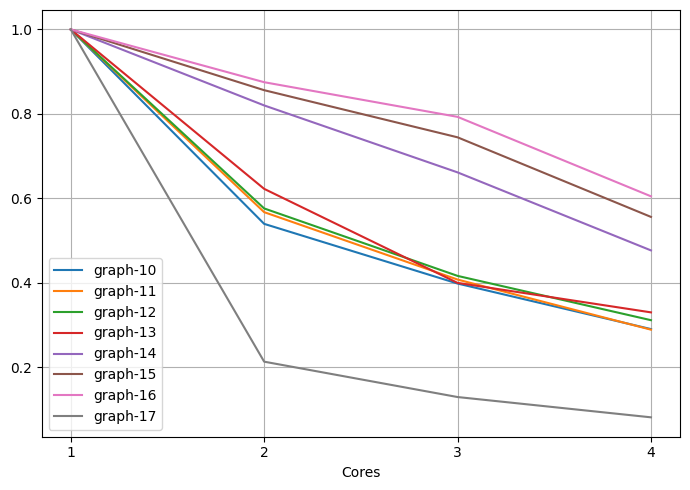

In [65]:
graphs = sorted(omp_refactored.keys(), key= lambda x: int(x.replace("graph-", "")))
for impl in ["nodes", "edges"]:
        for metric in ["speedup" ,"strong"]:
                plt.figure(figsize=(7, 5))
                for graph in graphs[:10]:
                        data = [omp_refactored[graph][impl][cores][f"total-{metric}"] for cores in range(1, 5)]
                        plt.plot([1, 2, 3, 4], data, label=graph)
                plt.legend()
                plt.xticks([1,2,3,4])
                plt.xlabel("Cores")
                plt.tight_layout()
                plt.grid(True)
                metric_name = metric
                plt.savefig(f"imgs/{metric}_{impl}_0_9_omp.pdf", format="pdf")
                plt.show()
                plt.figure(figsize=(7, 5))
                graphs = sorted(omp_refactored.keys(), key= lambda x: int(x.replace("graph-", "")))
                for graph in graphs[10:]:
                        data = [omp_refactored[graph][impl][cores][f"total-{metric}"] for cores in range(1, 5)]
                        plt.plot([1, 2, 3, 4], data, label=graph)
                plt.legend()
                plt.xticks([1,2,3,4])
                plt.grid(True)
                plt.xlabel("Cores")
                plt.tight_layout()
                plt.savefig(f"imgs/{metric}_{impl}_10_20_omp.pdf", format="pdf")

In [66]:
descs = []
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]:
    f = open(f"graphs/graph_{i}.txt")
    content = f.read()
    content = content.splitlines()
    header = content[0]
    content = content[1:]
    n_nodes = len(header.split(","))
    n_edges = 0
    for line in content:
        for edge in line.split(","):
            if edge != "0":
                n_edges += 1
    descs.append({
        "name": f"graph_{i}",
        "nodes": n_nodes,
        "edges": n_edges
    })
    
descs_dict = {d["name"]: {"nodes": d["nodes"], "edges": d["edges"]} for d in descs}

In [67]:
f = open(f"graphs/graph_weak1.txt")
content = f.read()
f.close()
content = content.splitlines()
header = content[0]
content = content[1:]
n_nodes = len(header.split(","))
n_edges = 0
for line in content:
    for edge in line.split(","):
        if edge != "0":
            n_edges += 1
{
        "name": f"graph_{i}",
        "nodes": n_nodes,
        "edges": n_edges
    }

{'name': 'graph_17', 'nodes': 600, 'edges': 359024}

In [68]:
omp_refactored = {}
for i in range(10):
    key = str(i)
    run = omp[key]
    for execution in run:
        if not key_make(execution["input_file"]) in omp_refactored:
            omp_refactored[key_make(execution["input_file"]) ] = {
                "edges": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}, 
                "nodes": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}
            }
        for time_type in time_types:
            omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])][time_type].append(execution["edges"][time_type])
            omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])][time_type].append(execution["nodes"][time_type])
        omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])]["total"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])]["total"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
stats = {}
for key in omp_refactored:
    for cores in range(1, 5):
        stats[f"{key}-nodes-{cores}-cores"] =  omp_refactored[key]["nodes"][cores]["total"] 
        stats[f"{key}-edges-{cores}-cores"] =  omp_refactored[key]["edges"][cores]["total"] 
stats_1 = {k:v for k, v in sorted(stats.items(), key= lambda x: int(x[0].split("-")[1])) if int(k.split("-")[1]) in [15, 16]}

In [69]:
all = []
for v in stats_1.values():
    all += v

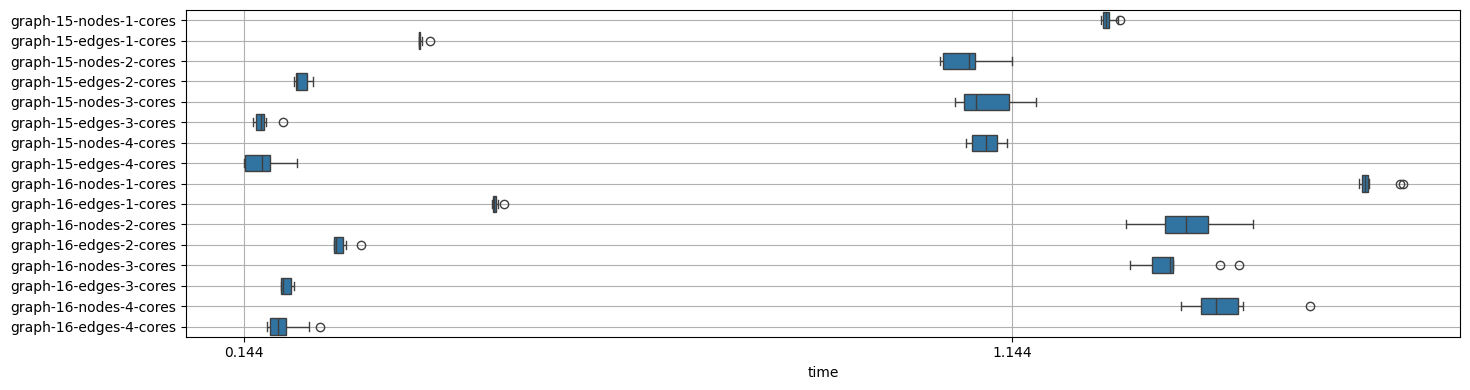

In [70]:
plt.figure(figsize=(15,4))
df = pd.DataFrame([(key, value) for key, values in stats_1.items() for value in values], columns=['Category', 'Value'])
sns.boxplot(x='Value', y='Category', data=df, orient='h')
plt.grid(True)
plt.xticks(np.arange(np.min(all), np.max(all)))
plt.tight_layout()
plt.xlabel('time')
plt.ylabel("")
plt.savefig("imgs/diff-comp_omp.pdf", format="pdf")
plt.show()

In [71]:
f = open("cuda_res_slurm.json")
cuda = json.load(f)
f.close()

In [72]:
cuda_refactored = {}
for i in range(10):
    key = str(i)
    run = cuda[key]
    for execution in run:
        if not key_make(execution["input_file"]) in cuda_refactored:
            cuda_refactored[key_make(execution["input_file"]) ] = {
                "edges": {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []}, 
                "nodes": {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []}
            }
        for time_type in time_types:
            cuda_refactored[key_make(execution["input_file"])]["edges"][time_type].append(execution["edges"][time_type])
            cuda_refactored[key_make(execution["input_file"])]["nodes"][time_type].append(execution["nodes"][time_type])
        cuda_refactored[key_make(execution["input_file"])]["edges"]["total"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        cuda_refactored[key_make(execution["input_file"])]["nodes"]["total"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
stats = {}
for key in cuda_refactored:
    stats[f"{key}-nodes"] =  cuda_refactored[key]["nodes"]["total"] 
    stats[f"{key}-edges"] =  cuda_refactored[key]["edges"]["total"] 

stats = {k:v for k,v in sorted(stats.items(), key= lambda x: int(x[0].split("-")[1])) if int(k.split("-")[1]) > 9}
all = []
for v in stats.values():
    all += v

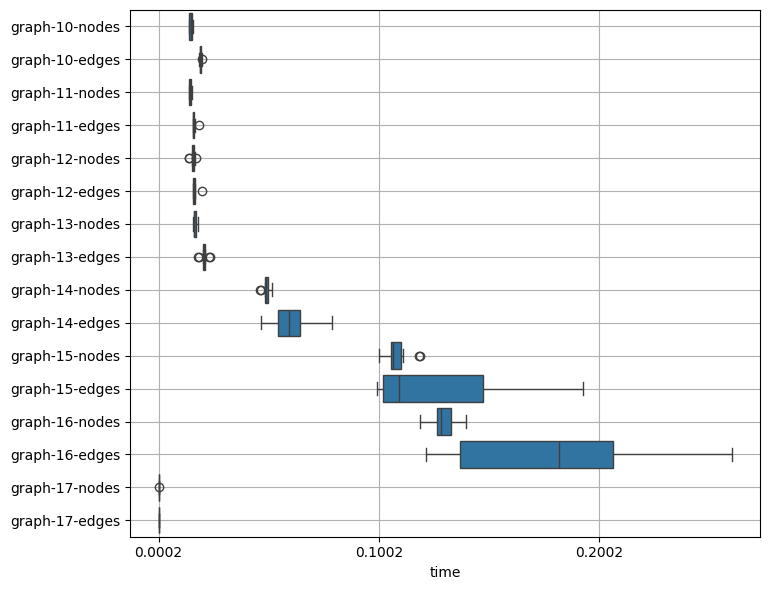

In [73]:
plt.figure(figsize=(8,6))
df = pd.DataFrame([(key, value) for key, values in stats.items() for value in values], columns=['Category', 'Value'])
sns.boxplot(x='Value', y='Category', data=df, orient='h')
plt.grid(True)
plt.xticks(np.arange(np.min(all), np.max(all), 0.1))
plt.tight_layout()
plt.xlabel('time')
plt.ylabel("")
plt.savefig("imgs/diff-comp_cuda.pdf", format="pdf")
plt.show()

In [74]:
for graph in cuda_refactored:
    throughtput_nodes = (descs_dict[graph.replace("-", "_")]["nodes"] ** 2) / np.mean(cuda_refactored[graph]["nodes"]["total"])
    cuda_refactored[graph]["nodes"]["throughtput"] = throughtput_nodes
    
    throughtput_edges = (3 * descs_dict[graph.replace("-", "_")]["edges"]) / np.mean(cuda_refactored[graph]["edges"]["total"])
    cuda_refactored[graph]["edges"]["throughtput"] = throughtput_nodes
cuda_local_refactored_nodes = {k:v for k, v in sorted(cuda_refactored.items(), key= lambda x: descs_dict[x[0].replace("-", "_")]["nodes"])}
cuda_local_refactored_edges = {k:v for k, v in sorted(cuda_refactored.items(), key= lambda x: descs_dict[x[0].replace("-", "_")]["edges"])}
x_nodes, y_nodes = [], []
x_edges, y_edges = [], []
for graph in cuda_local_refactored_nodes:
    x_nodes.append(descs_dict[graph.replace("-", "_")]["nodes"] ** 2)
    y_nodes.append(cuda_refactored[graph]["nodes"]["throughtput"])
for graph in cuda_local_refactored_edges:
    x_edges.append(descs_dict[graph.replace("-", "_")]["edges"] * 3)
    y_edges.append(cuda_refactored[graph]["edges"]["throughtput"])
nodes_dict = {}
for i in range(len(x_nodes)):
    if not x_nodes[i] in nodes_dict:
        nodes_dict[x_nodes[i]] = []
    nodes_dict[x_nodes[i]].append(y_nodes[i])
nodes_dict = {k: np.mean(v) for k,v in nodes_dict.items()}

edges_dict = {}
for i in range(len(x_edges)):
    if not x_nodes[i] in edges_dict:
        edges_dict[x_edges[i]] = []
    edges_dict[x_edges[i]].append(y_edges[i])
edges_dict = {k: np.mean(v) for k,v in edges_dict.items()}

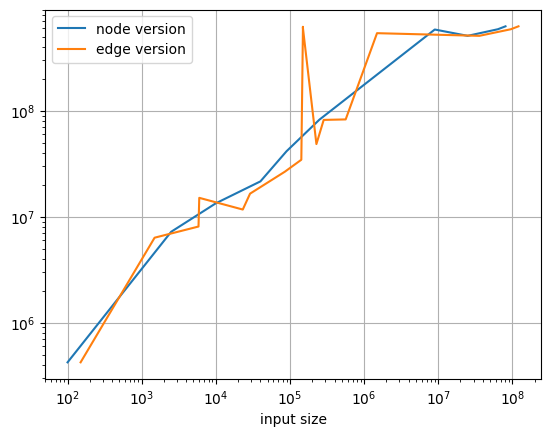

In [75]:
plt.plot(list(nodes_dict.keys()), list(nodes_dict.values()), label="node version")
plt.plot(list(edges_dict.keys()), list(edges_dict.values()), label="edge version")
plt.grid(True)
plt.legend()
plt.xlabel("input size")
plt.xscale("log")
plt.yscale("log")
plt.savefig("imgs/throughtput.pdf", format="pdf")

In [76]:
speedup_time_nodes = {}
speedup_time_edges = {}
for graph in cuda_refactored:
    speedup_time_nodes[graph] = speedup(np.mean(omp_refactored[graph]["nodes"][1]["total"]), np.mean(cuda_refactored[graph]["nodes"]["total"]))
    speedup_time_edges[graph] = speedup(np.mean(omp_refactored[graph]["edges"][1]["total"]), np.mean(cuda_refactored[graph]["edges"]["total"]))
        

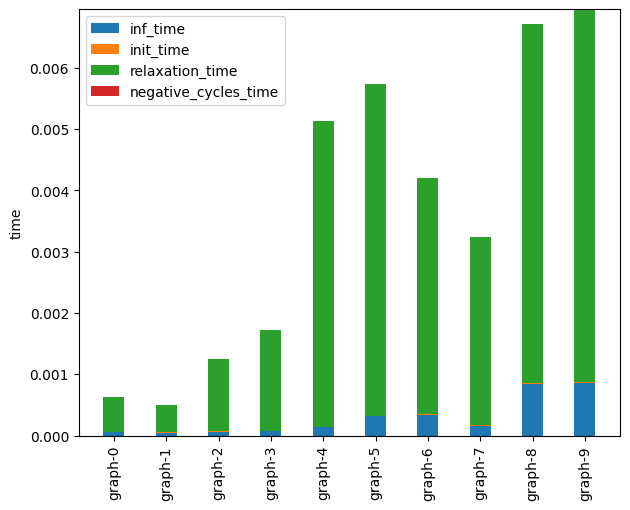

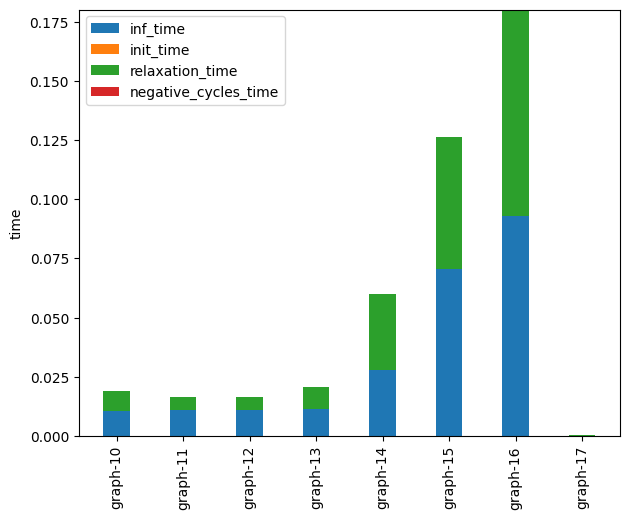

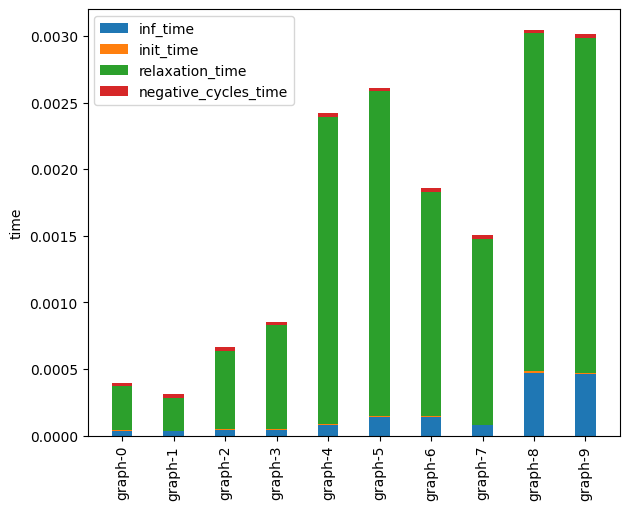

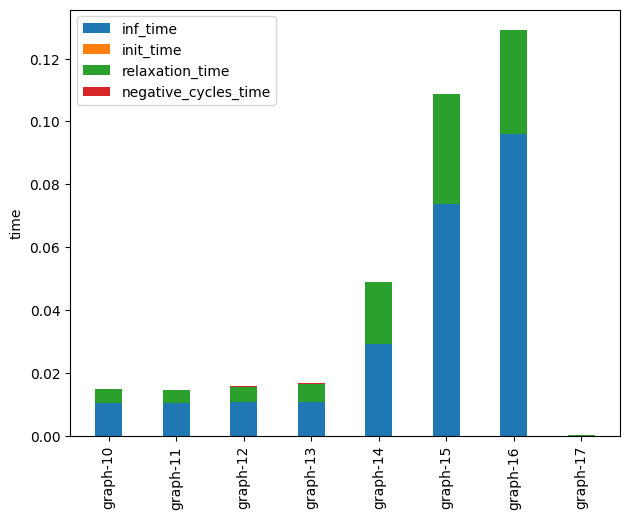

In [77]:
cuda_nodes = {}
cuda_edges = {}
for key in cuda_refactored:
    cuda_nodes[key] = {}
    cuda_edges[key] = {}
    cuda_nodes[key] = {time_type: np.mean(cuda_refactored[key]["nodes"][time_type]) for time_type in time_types}
    cuda_edges[key] = {time_type: np.mean(cuda_refactored[key]["edges"][time_type]) for time_type in time_types}
new_cuda_edges = {k:v for k, v in sorted(cuda_nodes.items(), key= lambda x: int(x[0].split("-")[1]))}
new_cuda_nodes = {k:v for k, v in sorted(cuda_edges.items(), key= lambda x: int(x[0].split("-")[1]))}
new_cuda_edges_1 = {k:v for k, v in new_cuda_edges.items() if int(k.split("-")[1]) < 10}
new_cuda_edges_2 = {k:v for k, v in new_cuda_edges.items() if int(k.split("-")[1]) >= 10}
new_cuda_nodes_1 = {k:v for k, v in new_cuda_nodes.items() if int(k.split("-")[1]) < 10}
new_cuda_nodes_2 = {k:v for k, v in new_cuda_nodes.items() if int(k.split("-")[1]) >= 10}
plot_cumullative_time(new_cuda_nodes_1, f"imgs/nodes-comp-0-9_cuda.pdf")
plot_cumullative_time(new_cuda_nodes_2, f"imgs/nodes-comp-10-17_cuda.pdf")
plot_cumullative_time(new_cuda_edges_1, f"imgs/edges-comp-0-9_cuda.pdf")
plot_cumullative_time(new_cuda_edges_2, f"imgs/edges-comp-10-17_cuda.pdf")

In [78]:
times_nodes = {}
times_edges = {}
for graph in cuda_refactored:
    times_nodes[graph] = np.mean(cuda_refactored[graph]["nodes"]["total"])
    times_edges[graph] = np.mean(cuda_refactored[graph]["edges"]["total"])

times_nodes = {k:v for k,v in sorted(times_nodes.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges = {k:v for k,v in sorted(times_edges.items(), key=lambda x: int(x[0].replace("graph-", "")))}

In [79]:
times_nodes_1 = {}
times_nodes_2 = {}
times_nodes_3 = {}
times_nodes_4 = {}
times_edges_1 = {}
times_edges_2 = {}
times_edges_3 = {}
times_edges_4 = {}
for graph in cuda_refactored:
    times_nodes_1[graph] = np.mean(omp_refactored[graph]["nodes"][1]["total"])
    times_nodes_2[graph] = np.mean(omp_refactored[graph]["nodes"][2]["total"])
    times_nodes_3[graph] = np.mean(omp_refactored[graph]["nodes"][3]["total"])
    times_nodes_4[graph] = np.mean(omp_refactored[graph]["nodes"][4]["total"])
    times_edges_1[graph] = np.mean(omp_refactored[graph]["edges"][1]["total"])
    times_edges_2[graph] = np.mean(omp_refactored[graph]["edges"][2]["total"])
    times_edges_3[graph] = np.mean(omp_refactored[graph]["edges"][3]["total"])
    times_edges_4[graph] = np.mean(omp_refactored[graph]["edges"][4]["total"])

times_nodes_1 = {k:v for k,v in sorted(times_nodes_1.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_nodes_2 = {k:v for k,v in sorted(times_nodes_2.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_nodes_3 = {k:v for k,v in sorted(times_nodes_3.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_nodes_4 = {k:v for k,v in sorted(times_nodes_4.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_1 = {k:v for k,v in sorted(times_edges_1.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_2 = {k:v for k,v in sorted(times_edges_2.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_3 = {k:v for k,v in sorted(times_edges_3.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_4 = {k:v for k,v in sorted(times_edges_4.items(), key=lambda x: int(x[0].replace("graph-", "")))}

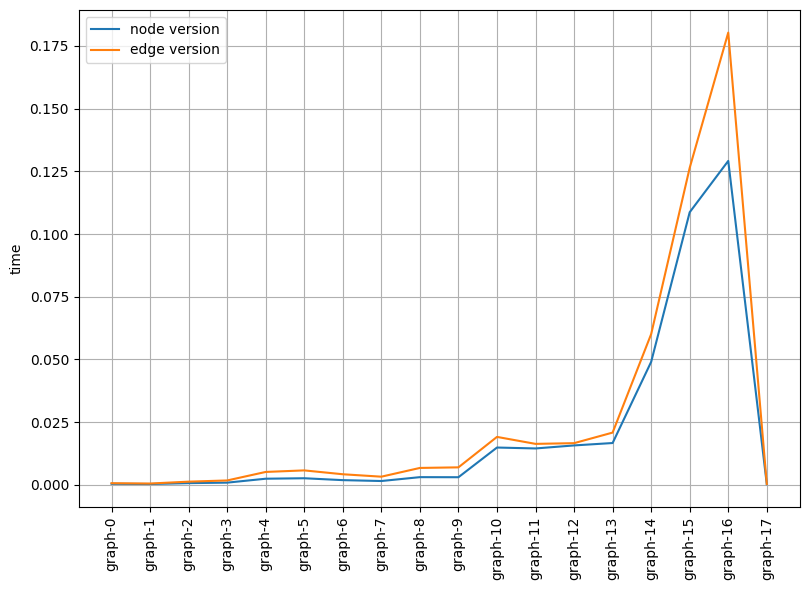

In [80]:
plt.figure(figsize=(8,6))
plt.plot(list(times_nodes.keys()), list(times_nodes.values()), label="node version")
plt.plot(list(times_edges.keys()), list(times_edges.values()), label="edge version")
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.ylabel("time")
plt.savefig("imgs/times_cuda.pdf", format="pdf")

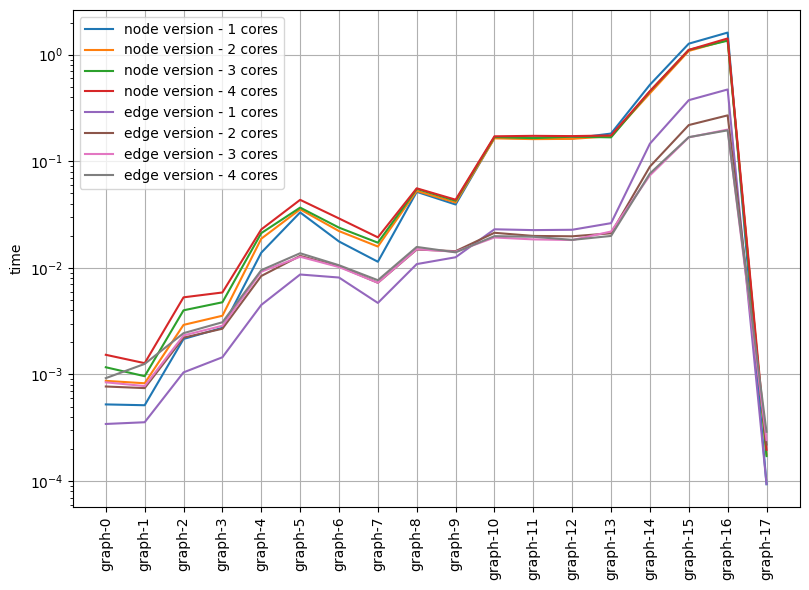

In [81]:
plt.figure(figsize=(8,6))
plt.plot(list(times_nodes_1.keys()), list(times_nodes_1.values()), label="node version - 1 cores")
plt.plot(list(times_nodes_2.keys()), list(times_nodes_2.values()), label="node version - 2 cores")
plt.plot(list(times_nodes_3.keys()), list(times_nodes_3.values()), label="node version - 3 cores")
plt.plot(list(times_nodes_4.keys()), list(times_nodes_4.values()), label="node version - 4 cores")
plt.plot(list(times_edges_1.keys()), list(times_edges_1.values()), label="edge version - 1 cores")
plt.plot(list(times_edges_2.keys()), list(times_edges_2.values()), label="edge version - 2 cores")
plt.plot(list(times_edges_3.keys()), list(times_edges_3.values()), label="edge version - 3 cores")
plt.plot(list(times_edges_4.keys()), list(times_edges_4.values()), label="edge version - 4 cores")
plt.grid(True)
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.legend()
plt.ylabel("time")
plt.savefig("imgs/times_omp.pdf", format="pdf")

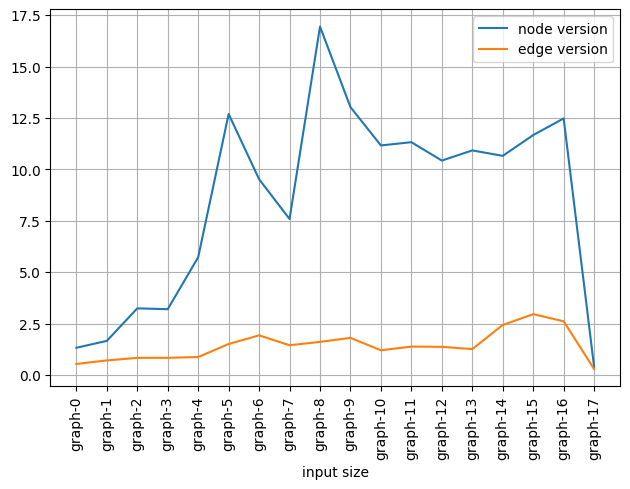

In [82]:
speedup_time_nodes = {k:v for k,v in sorted(speedup_time_nodes.items(), key=lambda x: int(x[0].replace("graph-", "")))}
speedup_time_edges = {k:v for k,v in sorted(speedup_time_edges.items(), key=lambda x: int(x[0].replace("graph-", "")))}

plt.plot(list(speedup_time_nodes.keys()), list(speedup_time_nodes.values()), label="node version")
plt.plot(list(speedup_time_edges.keys()), list(speedup_time_edges.values()), label="edge version")
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.xlabel("input size")
plt.savefig("imgs/speedup_cuda_wrt_seq.pdf", format="pdf")

In [83]:
f = open("omp_res_local.json")
omp = json.load(f)
f.close()

In [84]:
omp_refactored = {}
for i in range(10):
    key = str(i)
    run = omp[key]
    for execution in run:
        if not key_make(execution["input_file"]) in omp_refactored:
            omp_refactored[key_make(execution["input_file"]) ] = {
                "edges": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}, 
                "nodes": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}
            }
        for time_type in time_types:
            omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])][time_type].append(execution["edges"][time_type])
            omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])][time_type].append(execution["nodes"][time_type])
        omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])]["total"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])]["total"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
for key in omp_refactored:
    for cores in range(1, 5):
        omp_refactored[key]["nodes"][cores] = {time_type: np.mean(omp_refactored[key]["nodes"][cores][time_type]) for time_type in time_types + ["total"]}
        omp_refactored[key]["edges"][cores] = {time_type: np.mean(omp_refactored[key]["edges"][cores][time_type]) for time_type in time_types + ["total"]}
    

In [85]:
for graph in omp_refactored.keys():
    for cores in range(1, 5):
        for time_type in time_types + ["total"]:
            omp_refactored[graph]["nodes"][cores][f"{time_type}-speedup"] = speedup(omp_refactored[graph]["nodes"][1][time_type], 
                                                                                        omp_refactored[graph]["nodes"][cores][time_type])
            omp_refactored[graph]["nodes"][cores][f"{time_type}-strong"] = strong_efficency(omp_refactored[graph]["nodes"][1][time_type], 
                                                                                            omp_refactored[graph]["nodes"][cores][time_type], cores)
            omp_refactored[graph]["edges"][cores][f"{time_type}-speedup"] = speedup(omp_refactored[graph]["edges"][1][time_type], 
                                                                                        omp_refactored[graph]["edges"][cores][time_type])
            omp_refactored[graph]["edges"][cores][f"{time_type}-strong"] = strong_efficency(omp_refactored[graph]["edges"][1][time_type], 
                                                                                            omp_refactored[graph]["edges"][cores][time_type], cores)

/tmp/ipykernel_1394/1602110439.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return serial_time / parallel_time
/tmp/ipykernel_1394/1602110439.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return (serial_time) / (parallel_time * cores)


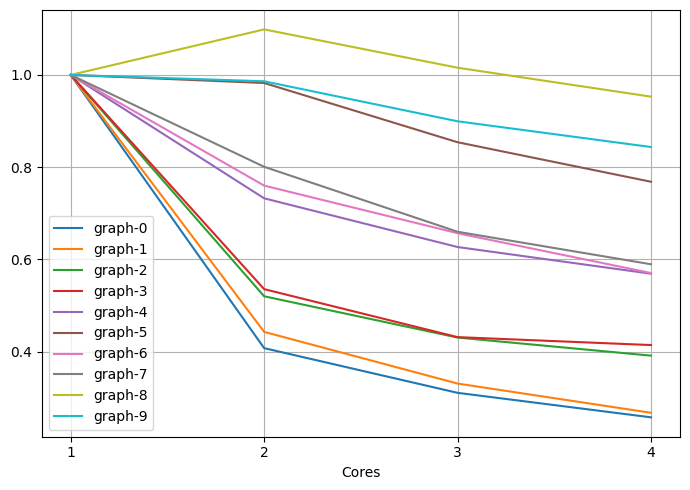

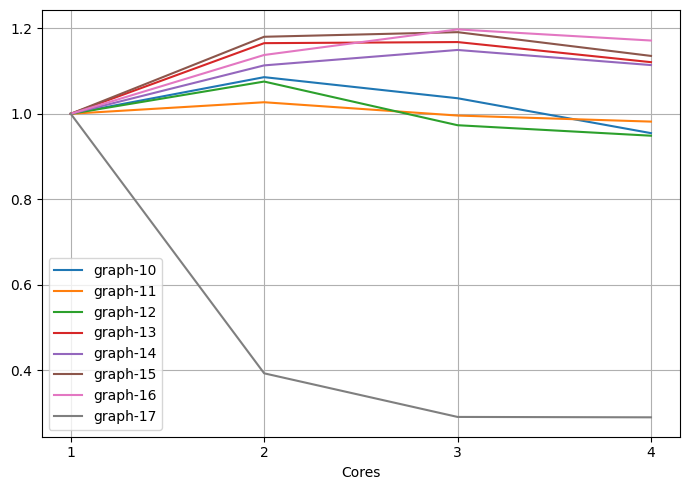

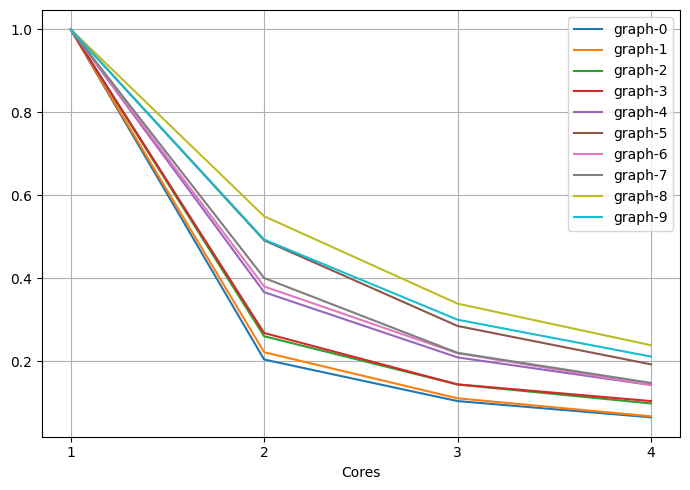

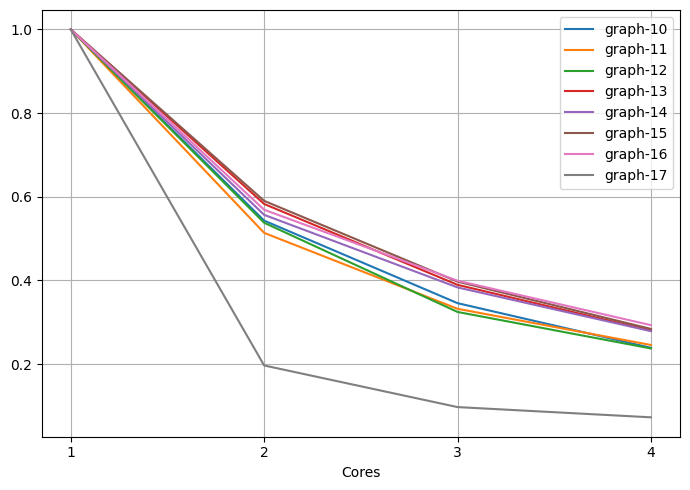

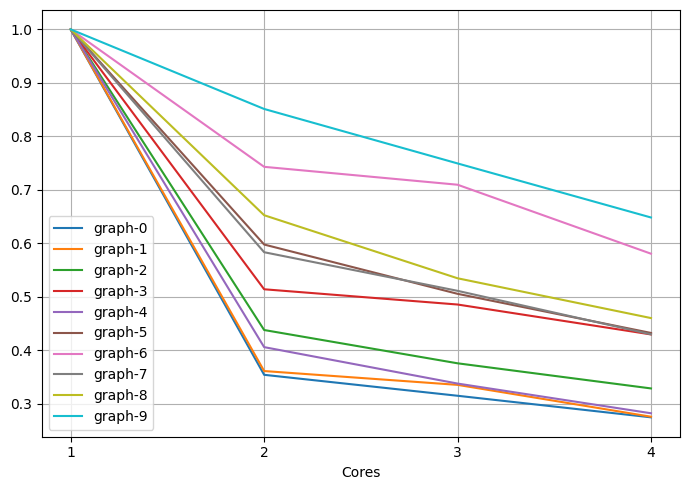

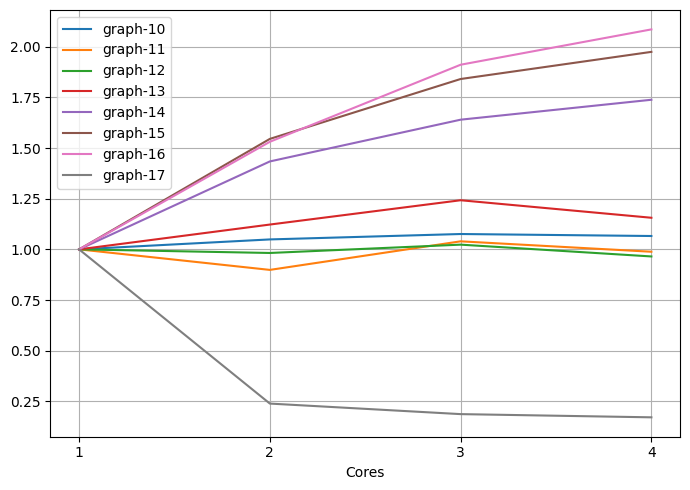

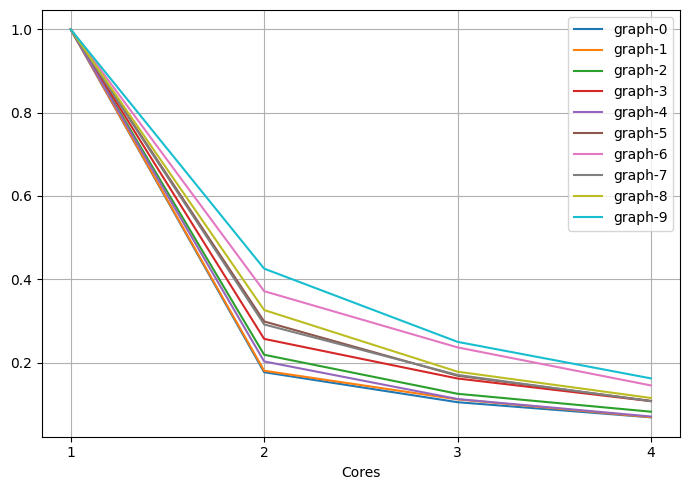

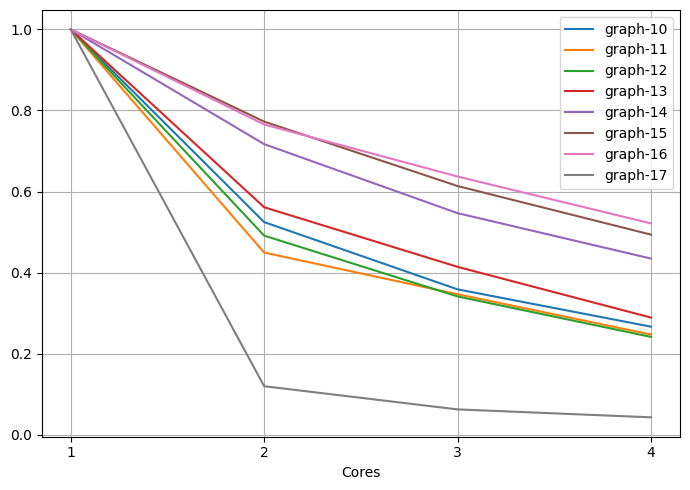

In [86]:
graphs = sorted(omp_refactored.keys(), key= lambda x: int(x.replace("graph-", "")))
for impl in ["nodes", "edges"]:
        for metric in ["speedup" ,"strong"]:
                plt.figure(figsize=(7, 5))
                for graph in graphs[:10]:
                        data = [omp_refactored[graph][impl][cores][f"total-{metric}"] for cores in range(1, 5)]
                        plt.plot([1, 2, 3, 4], data, label=graph)
                plt.legend()
                plt.xticks([1,2,3,4])
                plt.xlabel("Cores")
                plt.tight_layout()
                plt.grid(True)
                metric_name = metric
                plt.savefig(f"imgs/{metric}_{impl}_0_9_omp_local.pdf", format="pdf")
                plt.show()
                plt.figure(figsize=(7, 5))
                graphs = sorted(omp_refactored.keys(), key= lambda x: int(x.replace("graph-", "")))
                for graph in graphs[10:]:
                        data = [omp_refactored[graph][impl][cores][f"total-{metric}"] for cores in range(1, 5)]
                        plt.plot([1, 2, 3, 4], data, label=graph)
                plt.legend()
                plt.xticks([1,2,3,4])
                plt.grid(True)
                plt.xlabel("Cores")
                plt.tight_layout()
                plt.savefig(f"imgs/{metric}_{impl}_10_20_omp_local.pdf", format="pdf")

In [87]:
omp_refactored = {}
for i in range(10):
    key = str(i)
    run = omp[key]
    for execution in run:
        if not key_make(execution["input_file"]) in omp_refactored:
            omp_refactored[key_make(execution["input_file"]) ] = {
                "edges": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}, 
                "nodes": {cores: {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []} for cores in range(1, 5)}
            }
        for time_type in time_types:
            omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])][time_type].append(execution["edges"][time_type])
            omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])][time_type].append(execution["nodes"][time_type])
        omp_refactored[key_make(execution["input_file"])]["edges"][int(execution["cores"])]["total"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        omp_refactored[key_make(execution["input_file"])]["nodes"][int(execution["cores"])]["total"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
stats = {}
for key in omp_refactored:
    for cores in range(1, 5):
        stats[f"{key}-nodes-{cores}-cores"] =  omp_refactored[key]["nodes"][cores]["total"] 
        stats[f"{key}-edges-{cores}-cores"] =  omp_refactored[key]["edges"][cores]["total"] 
stats_1 = {k:v for k, v in sorted(stats.items(), key= lambda x: int(x[0].split("-")[1])) if int(k.split("-")[1]) in [15, 16]}

In [88]:
all = []
for v in stats_1.values():
    all += v

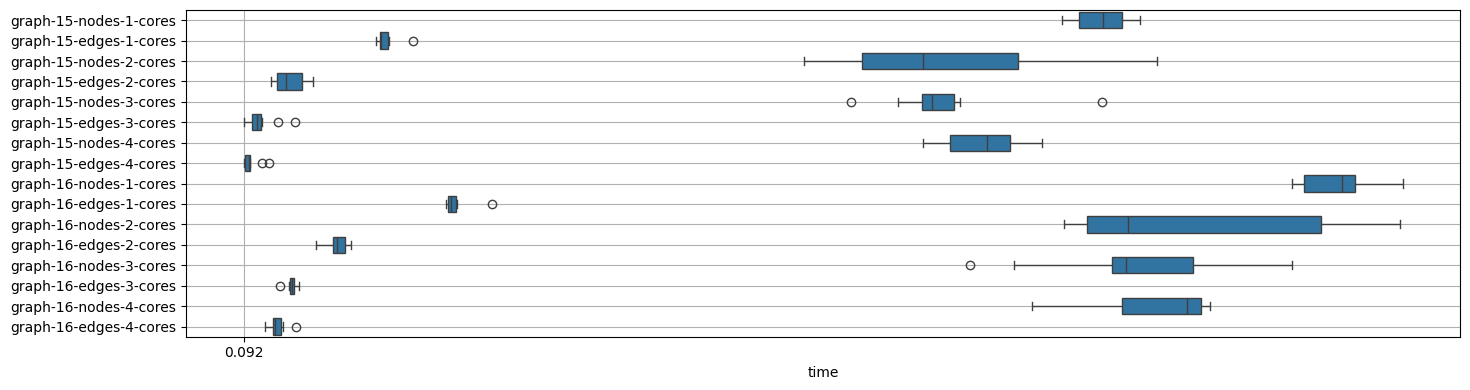

In [89]:
plt.figure(figsize=(15,4))
df = pd.DataFrame([(key, value) for key, values in stats_1.items() for value in values], columns=['Category', 'Value'])
sns.boxplot(x='Value', y='Category', data=df, orient='h')
plt.grid(True)
plt.xticks(np.arange(np.min(all), np.max(all)))
plt.tight_layout()
plt.xlabel('time')
plt.ylabel("")
plt.savefig("imgs/diff-comp_omp_local.pdf", format="pdf")
plt.show()

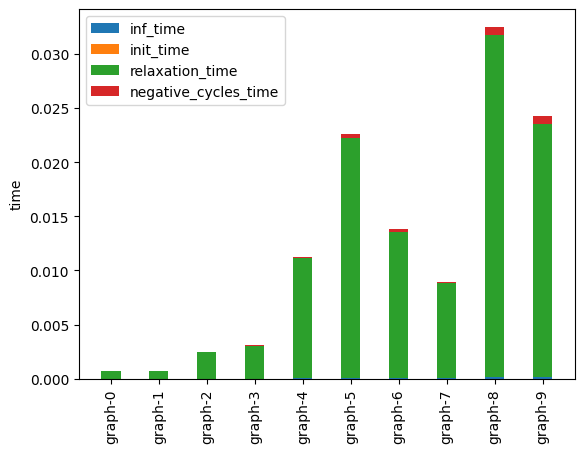

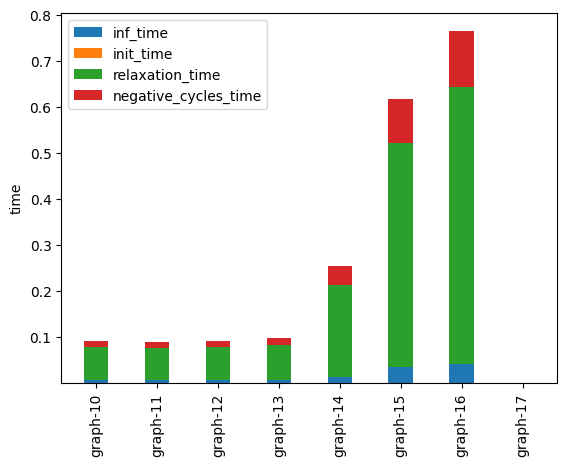

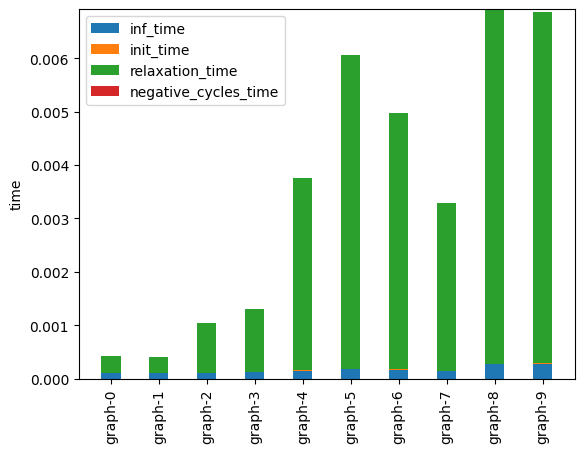

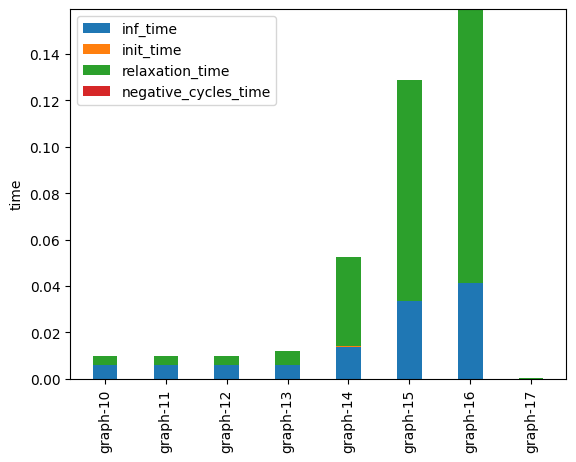

In [232]:
new_omp_nodes = {}
new_omp_edges = {}
for key in omp_refactored:
    new_omp_nodes[key] = {}
    new_omp_edges[key] = {}
    new_omp_nodes[key] = {time_type: np.mean([omp_refactored[key]["nodes"][cores][time_type] for cores in range (1, 5)]) for time_type in time_types}
    new_omp_edges[key] = {time_type: np.mean([omp_refactored[key]["edges"][cores][time_type] for cores in range (1, 5)]) for time_type in time_types}
new_omp_edges = {k:v for k, v in sorted(new_omp_edges.items(), key= lambda x: int(x[0].split("-")[1]))}
new_omp_nodes = {k:v for k, v in sorted(new_omp_nodes.items(), key= lambda x: int(x[0].split("-")[1]))}
new_omp_edges_1 = {k:v for k, v in new_omp_edges.items() if int(k.split("-")[1]) < 10}
new_omp_edges_2 = {k:v for k, v in new_omp_edges.items() if int(k.split("-")[1]) >= 10}
new_omp_nodes_1 = {k:v for k, v in new_omp_nodes.items() if int(k.split("-")[1]) < 10}
new_omp_nodes_2 = {k:v for k, v in new_omp_nodes.items() if int(k.split("-")[1]) >= 10}
plot_cumullative_time(new_omp_nodes_1, f"imgs/nodes-comp-0-9_omp_local.pdf")
plot_cumullative_time(new_omp_nodes_2, f"imgs/nodes-comp-10-17_omp_local.pdf")
plot_cumullative_time(new_omp_edges_1, f"imgs/edges-comp-0-9_omp_local.pdf")
plot_cumullative_time(new_omp_edges_2, f"imgs/edges-comp-10-17_omp_local.pdf")

In [91]:
f = open("cuda_res_local.json")
cuda = json.load(f)
f.close()

In [92]:
cuda_refactored = {}
for i in range(10):
    key = str(i)
    run = cuda[key]
    for execution in run:
        if not key_make(execution["input_file"]) in cuda_refactored:
            cuda_refactored[key_make(execution["input_file"]) ] = {
                "edges": {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []}, 
                "nodes": {"inf_time": [], "init_time": [], "relaxation_time": [], "negative_cycles_time": [], "total": []}
            }
        for time_type in time_types:
            cuda_refactored[key_make(execution["input_file"])]["edges"][time_type].append(execution["edges"][time_type])
            cuda_refactored[key_make(execution["input_file"])]["nodes"][time_type].append(execution["nodes"][time_type])
        cuda_refactored[key_make(execution["input_file"])]["edges"]["total"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        cuda_refactored[key_make(execution["input_file"])]["nodes"]["total"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
stats = {}
for key in cuda_refactored:
    stats[f"{key}-nodes"] =  cuda_refactored[key]["nodes"]["total"] 
    stats[f"{key}-edges"] =  cuda_refactored[key]["edges"]["total"] 

stats = {k:v for k,v in sorted(stats.items(), key= lambda x: int(x[0].split("-")[1])) if int(k.split("-")[1]) > 9}
all = []
for v in stats.values():
    all += v

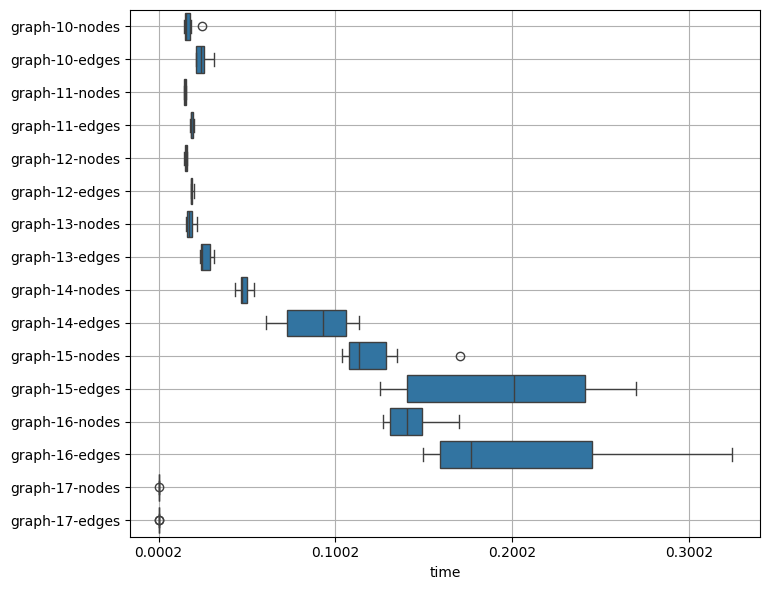

In [93]:
plt.figure(figsize=(8,6))
df = pd.DataFrame([(key, value) for key, values in stats.items() for value in values], columns=['Category', 'Value'])
sns.boxplot(x='Value', y='Category', data=df, orient='h')
plt.grid(True)
plt.xticks(np.arange(np.min(all), np.max(all), 0.1))
plt.tight_layout()
plt.xlabel('time')
plt.ylabel("")
plt.savefig("imgs/diff-comp_cuda_local.pdf", format="pdf")
plt.show()

In [94]:
for graph in cuda_refactored:
    throughtput_nodes = (descs_dict[graph.replace("-", "_")]["nodes"] ** 2) / np.mean(cuda_refactored[graph]["nodes"]["total"])
    cuda_refactored[graph]["nodes"]["throughtput"] = throughtput_nodes
    
    throughtput_edges = (3 * descs_dict[graph.replace("-", "_")]["edges"]) / np.mean(cuda_refactored[graph]["edges"]["total"])
    cuda_refactored[graph]["edges"]["throughtput"] = throughtput_nodes
cuda_local_refactored_nodes = {k:v for k, v in sorted(cuda_refactored.items(), key= lambda x: descs_dict[x[0].replace("-", "_")]["nodes"])}
cuda_local_refactored_edges = {k:v for k, v in sorted(cuda_refactored.items(), key= lambda x: descs_dict[x[0].replace("-", "_")]["edges"])}
x_nodes, y_nodes = [], []
x_edges, y_edges = [], []
for graph in cuda_local_refactored_nodes:
    x_nodes.append(descs_dict[graph.replace("-", "_")]["nodes"] ** 2)
    y_nodes.append(cuda_refactored[graph]["nodes"]["throughtput"])
for graph in cuda_local_refactored_edges:
    x_edges.append(descs_dict[graph.replace("-", "_")]["edges"] * 3)
    y_edges.append(cuda_refactored[graph]["edges"]["throughtput"])
nodes_dict = {}
for i in range(len(x_nodes)):
    if not x_nodes[i] in nodes_dict:
        nodes_dict[x_nodes[i]] = []
    nodes_dict[x_nodes[i]].append(y_nodes[i])
nodes_dict = {k: np.mean(v) for k,v in nodes_dict.items()}

edges_dict = {}
for i in range(len(x_edges)):
    if not x_nodes[i] in edges_dict:
        edges_dict[x_edges[i]] = []
    edges_dict[x_edges[i]].append(y_edges[i])
edges_dict = {k: np.mean(v) for k,v in edges_dict.items()}

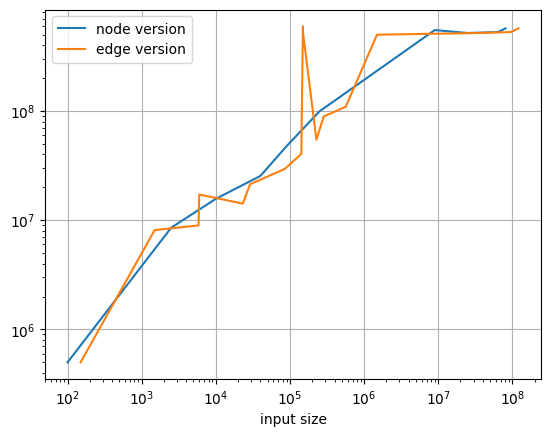

In [95]:
plt.plot(list(nodes_dict.keys()), list(nodes_dict.values()), label="node version")
plt.plot(list(edges_dict.keys()), list(edges_dict.values()), label="edge version")
plt.grid(True)
plt.legend()
plt.xlabel("input size")
plt.xscale("log")
plt.yscale("log")
plt.savefig("imgs/throughtput_local.pdf", format="pdf")

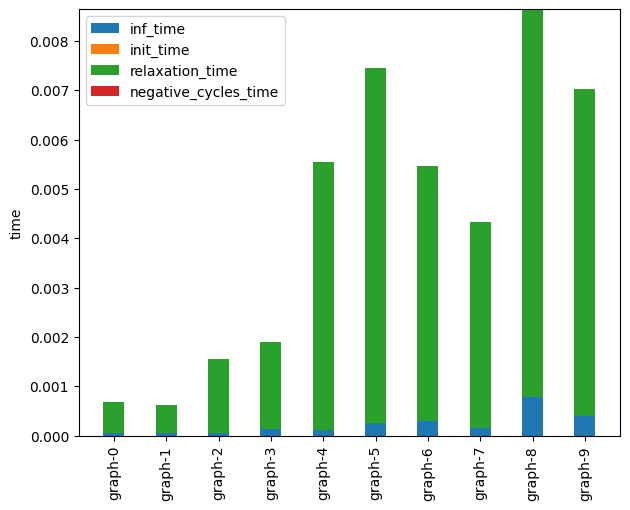

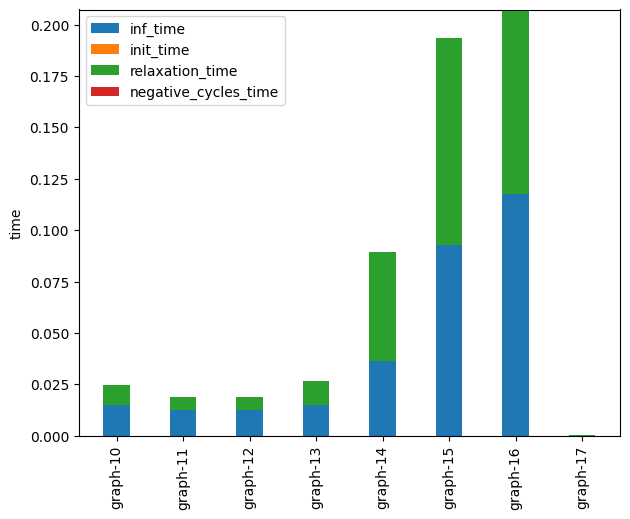

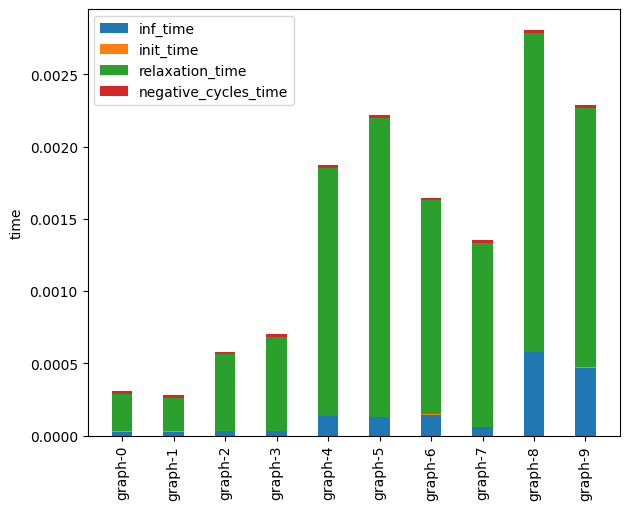

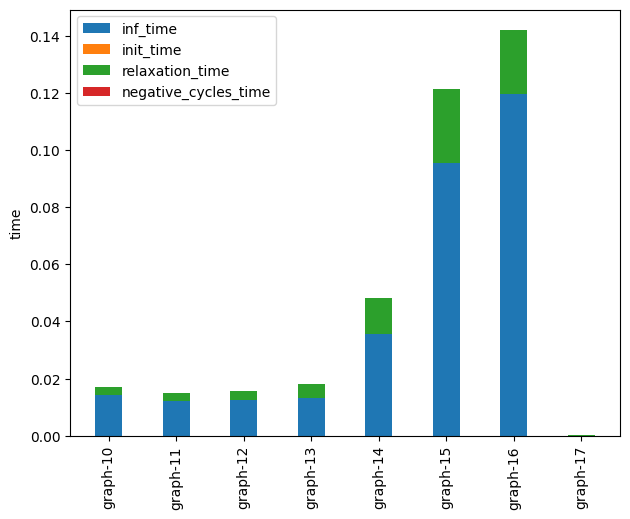

In [96]:
cuda_nodes = {}
cuda_edges = {}
for key in cuda_refactored:
    cuda_nodes[key] = {}
    cuda_edges[key] = {}
    cuda_nodes[key] = {time_type: np.mean(cuda_refactored[key]["nodes"][time_type]) for time_type in time_types}
    cuda_edges[key] = {time_type: np.mean(cuda_refactored[key]["edges"][time_type]) for time_type in time_types}
new_cuda_edges = {k:v for k, v in sorted(cuda_nodes.items(), key= lambda x: int(x[0].split("-")[1]))}
new_cuda_nodes = {k:v for k, v in sorted(cuda_edges.items(), key= lambda x: int(x[0].split("-")[1]))}
new_cuda_edges_1 = {k:v for k, v in new_cuda_edges.items() if int(k.split("-")[1]) < 10}
new_cuda_edges_2 = {k:v for k, v in new_cuda_edges.items() if int(k.split("-")[1]) >= 10}
new_cuda_nodes_1 = {k:v for k, v in new_cuda_nodes.items() if int(k.split("-")[1]) < 10}
new_cuda_nodes_2 = {k:v for k, v in new_cuda_nodes.items() if int(k.split("-")[1]) >= 10}
plot_cumullative_time(new_cuda_nodes_1, f"imgs/nodes-comp-0-9_cuda_local.pdf")
plot_cumullative_time(new_cuda_nodes_2, f"imgs/nodes-comp-10-17_cuda_local.pdf")
plot_cumullative_time(new_cuda_edges_1, f"imgs/edges-comp-0-9_cuda_local.pdf")
plot_cumullative_time(new_cuda_edges_2, f"imgs/edges-comp-10-17_cuda_local.pdf")

In [97]:
speedup_time_nodes = {}
speedup_time_edges = {}
for graph in cuda_refactored:
    speedup_time_nodes[graph] = speedup(np.mean(omp_refactored[graph]["nodes"][1]["total"]), np.mean(cuda_refactored[graph]["nodes"]["total"]))
    speedup_time_edges[graph] = speedup(np.mean(omp_refactored[graph]["edges"][1]["total"]), np.mean(cuda_refactored[graph]["edges"]["total"]))
        

In [98]:
times_nodes = {}
times_edges = {}
for graph in cuda_refactored:
    times_nodes[graph] = np.mean(cuda_refactored[graph]["nodes"]["total"])
    times_edges[graph] = np.mean(cuda_refactored[graph]["edges"]["total"])

times_nodes = {k:v for k,v in sorted(times_nodes.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges = {k:v for k,v in sorted(times_edges.items(), key=lambda x: int(x[0].replace("graph-", "")))}

In [99]:
times_nodes_1 = {}
times_nodes_2 = {}
times_nodes_3 = {}
times_nodes_4 = {}
times_edges_1 = {}
times_edges_2 = {}
times_edges_3 = {}
times_edges_4 = {}
for graph in cuda_refactored:
    times_nodes_1[graph] = np.mean(omp_refactored[graph]["nodes"][1]["total"])
    times_nodes_2[graph] = np.mean(omp_refactored[graph]["nodes"][2]["total"])
    times_nodes_3[graph] = np.mean(omp_refactored[graph]["nodes"][3]["total"])
    times_nodes_4[graph] = np.mean(omp_refactored[graph]["nodes"][4]["total"])
    times_edges_1[graph] = np.mean(omp_refactored[graph]["edges"][1]["total"])
    times_edges_2[graph] = np.mean(omp_refactored[graph]["edges"][2]["total"])
    times_edges_3[graph] = np.mean(omp_refactored[graph]["edges"][3]["total"])
    times_edges_4[graph] = np.mean(omp_refactored[graph]["edges"][4]["total"])

times_nodes_1 = {k:v for k,v in sorted(times_nodes_1.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_nodes_2 = {k:v for k,v in sorted(times_nodes_2.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_nodes_3 = {k:v for k,v in sorted(times_nodes_3.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_nodes_4 = {k:v for k,v in sorted(times_nodes_4.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_1 = {k:v for k,v in sorted(times_edges_1.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_2 = {k:v for k,v in sorted(times_edges_2.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_3 = {k:v for k,v in sorted(times_edges_3.items(), key=lambda x: int(x[0].replace("graph-", "")))}
times_edges_4 = {k:v for k,v in sorted(times_edges_4.items(), key=lambda x: int(x[0].replace("graph-", "")))}

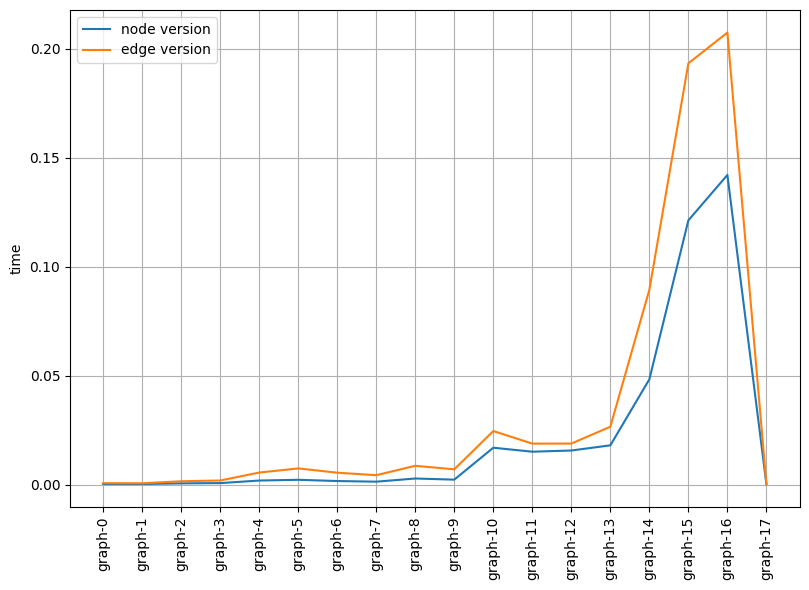

In [100]:
plt.figure(figsize=(8,6))
plt.plot(list(times_nodes.keys()), list(times_nodes.values()), label="node version")
plt.plot(list(times_edges.keys()), list(times_edges.values()), label="edge version")
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.ylabel("time")
plt.savefig("imgs/times_cuda_local.pdf", format="pdf")

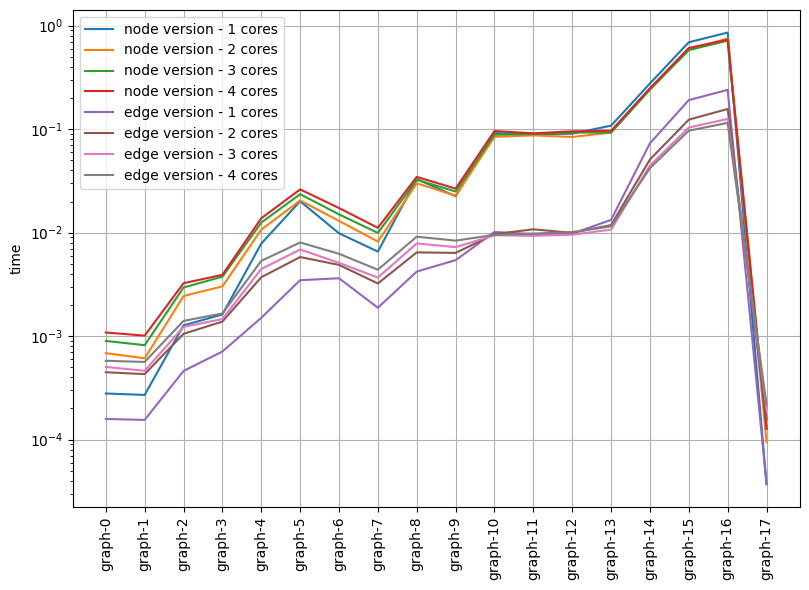

In [101]:
plt.figure(figsize=(8,6))
plt.plot(list(times_nodes_1.keys()), list(times_nodes_1.values()), label="node version - 1 cores")
plt.plot(list(times_nodes_2.keys()), list(times_nodes_2.values()), label="node version - 2 cores")
plt.plot(list(times_nodes_3.keys()), list(times_nodes_3.values()), label="node version - 3 cores")
plt.plot(list(times_nodes_4.keys()), list(times_nodes_4.values()), label="node version - 4 cores")
plt.plot(list(times_edges_1.keys()), list(times_edges_1.values()), label="edge version - 1 cores")
plt.plot(list(times_edges_2.keys()), list(times_edges_2.values()), label="edge version - 2 cores")
plt.plot(list(times_edges_3.keys()), list(times_edges_3.values()), label="edge version - 3 cores")
plt.plot(list(times_edges_4.keys()), list(times_edges_4.values()), label="edge version - 4 cores")
plt.grid(True)
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.legend()
plt.ylabel("time")
plt.savefig("imgs/times_omp_local.pdf", format="pdf")

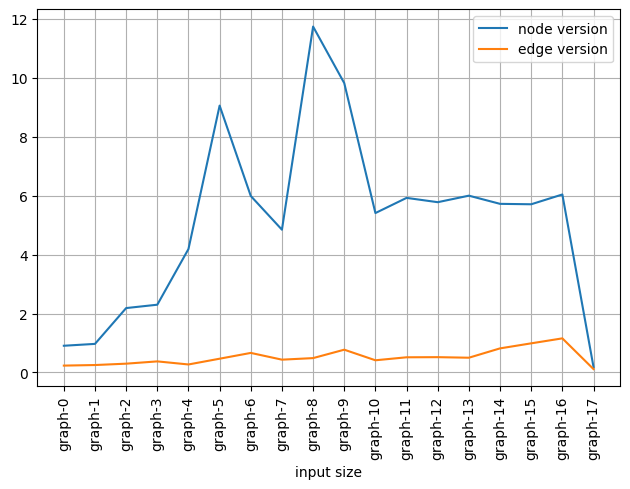

In [102]:
speedup_time_nodes = {k:v for k,v in sorted(speedup_time_nodes.items(), key=lambda x: int(x[0].replace("graph-", "")))}
speedup_time_edges = {k:v for k,v in sorted(speedup_time_edges.items(), key=lambda x: int(x[0].replace("graph-", "")))}

plt.plot(list(speedup_time_nodes.keys()), list(speedup_time_nodes.values()), label="node version")
plt.plot(list(speedup_time_edges.keys()), list(speedup_time_edges.values()), label="edge version")
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.xlabel("input size")
plt.savefig("imgs/speedup_cuda_wrt_seq_local.pdf", format="pdf")

In [218]:
f = open("omp_res_weak_slurm.json")
omp_weak = json.load(f)
f.close()

In [219]:
def weak(serial_time, parallel_time, cores):
    return serial_time / parallel_time

In [220]:
weak_refactored = {}
for i in range(10):
    key = str(i)
    run = omp_weak[key]
    for execution in run:
        execution = execution[0]
        if not key_make(execution["input_file"]) in weak_refactored:
            weak_refactored[key_make(execution["input_file"]) ] = {
                "edges": [], 
                "nodes": []
            }
        weak_refactored[key_make(execution["input_file"])]["edges"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        weak_refactored[key_make(execution["input_file"])]["nodes"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
for key in weak_refactored:
    weak_refactored[key]["edges"] = np.mean(weak_refactored[key]["edges"])
    weak_refactored[key]["nodes"] = np.mean(weak_refactored[key]["nodes"])

In [221]:
weak_res_edges = [
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak1"]["edges"], 1),
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak2"]["edges"], 2),
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak3"]["edges"], 3),
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak4"]["edges"], 4)
]
weak_res_nodes = [
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak1"]["nodes"], 1),
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak2"]["nodes"], 2),
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak3"]["nodes"], 3),
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak4"]["nodes"], 4)
]

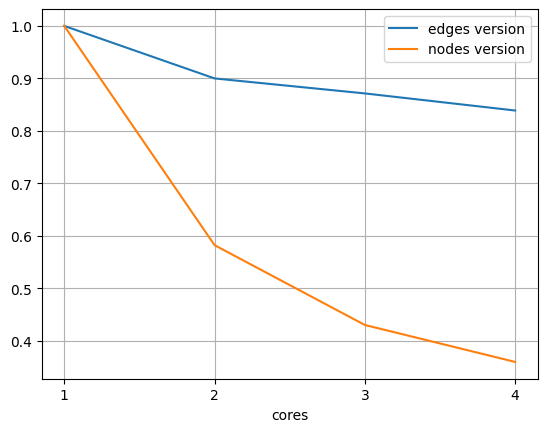

In [222]:
plt.plot([1, 2, 3, 4], weak_res_edges, label="edges version")
plt.plot([1, 2, 3, 4], weak_res_nodes, label="nodes version")
plt.legend()
plt.xlabel("cores")
plt.grid()
plt.xticks([1, 2, 3, 4])
plt.savefig("imgs/weak_efficiency.pdf", format="pdf")
plt.show()

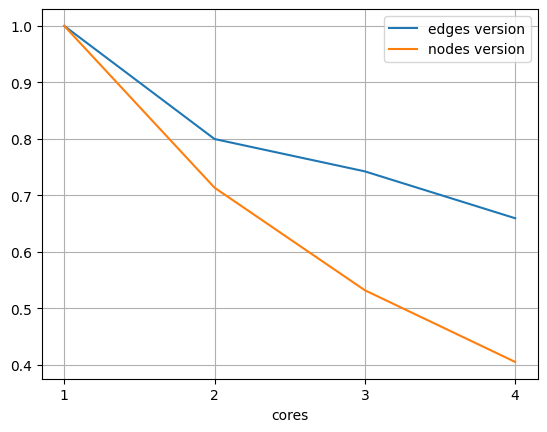

In [223]:
f = open("omp_res_weak_local.json")
omp_weak = json.load(f)
f.close()
weak_refactored = {}
for i in range(10):
    key = str(i)
    run = omp_weak[key]
    for execution in run:
        execution = execution[0]
        if not key_make(execution["input_file"]) in weak_refactored:
            weak_refactored[key_make(execution["input_file"]) ] = {
                "edges": [], 
                "nodes": []
            }
        weak_refactored[key_make(execution["input_file"])]["edges"].append(
            np.sum([execution["edges"][time_type] for time_type in time_types])
        )
        weak_refactored[key_make(execution["input_file"])]["nodes"].append(
            np.sum([execution["nodes"][time_type] for time_type in time_types])
        )
for key in weak_refactored:
    weak_refactored[key]["edges"] = np.mean(weak_refactored[key]["edges"])
    weak_refactored[key]["nodes"] = np.mean(weak_refactored[key]["nodes"])
weak_res_edges = [
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak1"]["edges"], 1),
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak2"]["edges"], 2),
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak3"]["edges"], 3),
    weak(weak_refactored["graph-weak1"]["edges"], weak_refactored["graph-weak4"]["edges"], 4)
]
weak_res_nodes = [
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak1"]["nodes"], 1),
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak2"]["nodes"], 2),
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak3"]["nodes"], 3),
    weak(weak_refactored["graph-weak1"]["nodes"], weak_refactored["graph-weak4"]["nodes"], 4)
]
plt.plot([1, 2, 3, 4], weak_res_edges, label="edges version")
plt.plot([1, 2, 3, 4], weak_res_nodes, label="nodes version")
plt.legend()
plt.xlabel("cores")
plt.grid()
plt.xticks([1, 2, 3, 4])
plt.savefig("imgs/weak_efficiency_local.pdf", format="pdf")
plt.show()